<a href="https://colab.research.google.com/github/MiguelHRSDE/W-Net/blob/dataset/W_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inicialization**


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# first some extra packages we're gonna need
!pip3 install coloredlogs
!pip install -q git+https://github.com/tensorflow/examples.git

%tensorflow_version 2.x
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np 
from tensorflow.python.keras import layers

from tensorflow.python.keras.layers import (Activation, AveragePooling2D,
                                            BatchNormalization, Conv2D, Conv3D,
                                            Dense, Flatten,
                                            GlobalAveragePooling2D,
                                            GlobalMaxPooling2D, Input,
                                            MaxPooling2D, MaxPooling3D,
                                            Reshape, Dropout, concatenate,
											UpSampling2D)
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K_B
import coloredlogs
from os.path import exists
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(tf.__version__)



2.1.0


# **Sof normalized cut loss implementation**

In [20]:
def edge_weights(flatten_image, rows , cols, std_intensity=3, std_position=1, radius=5):
	'''
	Inputs :
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels) 
	std_intensity : standard deviation for intensity 
	std_position : standard devistion for position
	radius : the length of the around the pixel where the weights 
	is non-zero
	rows : rows of the original image (unflattened image)
	cols : cols of the original image (unflattened image)

	Output : 
	weights :  2d tf array edge weights in the pixel graph

	Used parameters :
	n : number of pixels 
	'''
	A = outer_product(flatten_image, tf.ones_like(flatten_image))
	A_T = tf.transpose(A)
	intensity_weight = tf.exp(-1*tf.square((tf.divide((A - A_T), std_intensity))))

	xx, yy = tf.meshgrid(tf.range(rows), tf.range(cols))
	xx = tf.reshape(xx, (rows*cols,))
	yy = tf.reshape(yy, (rows*cols,))
	A_x = outer_product(xx, tf.ones_like(xx))
	A_y = outer_product(yy, tf.ones_like(yy))

	xi_xj = A_x - tf.transpose(A_x)
	yi_yj = A_y - tf.transpose(A_y)

	sq_distance_matrix = tf.square(xi_xj) + tf.square(yi_yj)

	dist_weight = tf.exp(-tf.divide(sq_distance_matrix,tf.square(std_position)))
	dist_weight = tf.cast(dist_weight, tf.float32)
	print (dist_weight.get_shape())
	print (intensity_weight.get_shape())
	weight = tf.multiply(intensity_weight, dist_weight)


	# ele_diff = tf.reshape(ele_diff, (rows, cols))
	# w = ele_diff + distance_matrix
	'''
	for i in range(n):
		for j in range(n):
			# because a (x,y) in the original image responds in (x-1)*cols + (y+1) in the flatten image
			x_i= (i//cols) +1 
			y_i= (i%cols) - 1
			x_j= (j//cols) + 1
			y_j= (j%cols) - 1
			distance = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
			if (distance < radius):
				w[i][j] = tf.exp(-((flatten_image[i]- flatten_image[j])/std_intensity)**2) * tf.exp(-(distance/std_position)**2)
	# return w as a lookup table			
	'''
	return weight

def outer_product(v1,v2):
	'''
	Inputs:
	v1 : m*1 tf array
	v2 : m*1 tf array

	Output :
	v1 x v2 : m*m array
	'''
	v1 = tf.reshape(v1, (-1,))
	v2 = tf.reshape(v2, (-1,))
	v1 = tf.expand_dims((v1), axis=0)
	v2 = tf.expand_dims((v2), axis=0)
	return tf.matmul(tf.transpose(v1),(v2))

def numerator(k_class_prob,weights):

	'''
	Inputs :
	k_class_prob : k_class pixelwise probability (rows*cols) tensor 
	weights : edge weights n*n tensor 
	'''
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,k_class_prob)))

def denominator(k_class_prob,weights):	
	'''
	Inputs:
	k_class_prob : k_class pixelwise probability (rows*cols) tensor
	weights : edge weights	n*n tensor 
	'''
	k_class_prob = tf.cast(k_class_prob, tf.float32)
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,tf.ones(tf.shape(k_class_prob)))))

def soft_n_cut_loss(flatten_image,prob, k, rows, cols):
	'''
	Inputs: 
	prob : (rows*cols*k) tensor 
	k : number of classes (integer)
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels)
	rows : number of the rows in the original image
	cols : number of the cols in the original image

	Output : 
	soft_n_cut_loss tensor for a single image

	'''

	soft_n_cut_loss = k
	weights = edge_weights(flatten_image, rows ,cols)
	
	for t in range(k): 
		soft_n_cut_loss = soft_n_cut_loss - (numerator(prob[:,:,t],weights)/denominator(prob[:,:,t],weights))

	return soft_n_cut_loss
	# return soft_n_cut_loss



print('check')

check


# **Load dataset**

(880, 9984)
tf.Tensor(
[[[  3.4700546 ]
  [  1.310051  ]
  [  1.360054  ]
  ...
  [ -0.9999466 ]
  [ -1.2599487 ]
  [  1.6800537 ]]

 [[  1.2000504 ]
  [ -1.7899475 ]
  [ -0.5399475 ]
  ...
  [  1.060051  ]
  [  1.4000549 ]
  [  2.2100525 ]]

 [[  1.0700531 ]
  [ -1.3299484 ]
  [ -1.6099472 ]
  ...
  [  0.09004974]
  [ -1.0399475 ]
  [  0.5700531 ]]

 ...

 [[ -1.7499466 ]
  [ -3.3999481 ]
  [ -0.40995026]
  ...
  [ -9.499947  ]
  [-10.459946  ]
  [ -8.7899475 ]]

 [[ -2.8199463 ]
  [  0.77005005]
  [ -0.8799515 ]
  ...
  [ -9.849945  ]
  [ -8.54995   ]
  [-10.939949  ]]

 [[ -0.43994904]
  [ -0.5699463 ]
  [ -1.1699448 ]
  ...
  [-10.3799515 ]
  [-10.889946  ]
  [ -9.72995   ]]], shape=(880, 128, 1), dtype=float32)


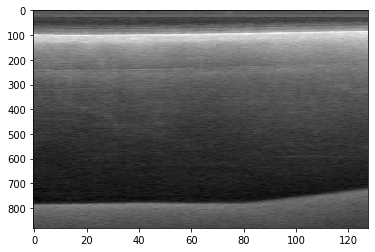

In [21]:
#Load dataset from a csv file
file = '/content/drive/My Drive/Per_Miguel/Dataset_ice_shelf/data_20181115_01/test.csv'
df=pd.read_csv(file,header=None)
d=df.values
data = np.float32(d)
data=data[20:900,0:9984] #78 patches
data -= np.mean(data) #mean substraction
print(data.shape)

#Divide radargram into patches
prueba=np.reshape(data,(880,128,78), order = 'F')
prueba = tf.transpose(prueba, perm = [2, 0, 1])
prueba = prueba[..., tf.newaxis] #add 3rd dimension
a = prueba[0,:,:,:] #checkpoint
plt.imshow(np.squeeze(a), cmap='gray', aspect='auto') 
print(prueba[0,:,:,:])

dataset = tf.data.Dataset.from_tensor_slices(prueba)

#Set dataser propierties
#TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 100
STEPS_PER_EPOCH = 19

#Customize dataset
train_dataset = dataset.cache().batch(BATCH_SIZE).repeat(2)
#train_dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

# **Constructing the W-Net**

## Define the model

In [0]:
img_rows = 880
img_cols = 128
num_classes = 4
bn_axis=3
display_step = 20

## Define encode/decode blocks

In [0]:
def enc_conv_block(inputs, filters=[128,128], kernel_size=[3,3], activation='relu', kernel_initializer='he_normal', block='', module='', pre_pool=True):
		fa, fb = filters
		ka, kb = kernel_size
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_1')(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_2')(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_bn_enc_'+block+'_3')(conv1)
		conv1 = Dropout(0.65,  name=module+'_dropout_enc_'+block)(conv1)
		pool1 = MaxPooling2D(pool_size=(2,2), name=module+'_maxpool_enc_'+block+'_4')(conv1)
		# tf.summary.histogram(module+'_maxpool_enc_'+block+'_4',pool1)
		if not pre_pool:
			return pool1
		else:
			return conv1,pool1

def dec_conv_block(inputs, filters=[128, 128, 128], kernel_size=[2,3,3], activation='relu', kernel_initializer='he_normal', block='', module=''):
		previous_layer, concat_layer = inputs
		fa, fb, fc = filters
		ka, kb, kc = kernel_size
		up1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_2')(UpSampling2D(size=(2,2), name=module+'_upsam_block_'+block+'_1')(previous_layer))
		# print (up1.get_shape())
		merge1 = concatenate([concat_layer, up1], name=module+'_concat_'+block+'_3')
		conv2 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_4')(merge1)
		conv3 = Conv2D(fc, kc, activation=activation, padding='same', kernel_initializer=kernel_initializer,name=module+'_conv_dec_'+block+'_5')(conv2)
		conv3 = Dropout(0.65, name=module+'_dropout_dec_'+block)(conv3)
		conv3 = BatchNormalization(axis=bn_axis, name=module+'_bn_dec_'+block+'_6')(conv3)
		# tf.summary.histogram(module+'_bn_dec_'+block+'_6', conv3)
		return conv3

def join_enc_dec(inputs, filters=[1024,1024], kernel=[3,3],activation='relu', kernel_initializer='he_normal', module='', block='join'):	
		fa, fb = filters
		ka, kb = kernel
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_1")(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_2")(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_join_bn_3_')(conv1)
		conv1 = Dropout(0.65, name=module+'_join_dropout_4')(conv1)
		# tf.summary.histogram(module+'_join_bn_3_', conv1)
		return conv1

## Define U-net

In [0]:
def unet(input_size=(-1,img_rows,img_cols,3), input_tensor=None, output_layers=1,module=''):
		
		if input_tensor is None:
			inputs = Input(input_size)
		else:
			inputs = input_tensor
		bn_axis=3
		with tf.name_scope(module+'_Encoder'):
			prepool_1, layer1 = enc_conv_block(inputs, [64, 64], [3,3], block='a', module=module)
			prepool_2, layer2 = enc_conv_block(layer1, [128,128], [3,3], block='b', module=module)
			prepool_3, layer3 = enc_conv_block(layer2, [256,256], [3,3], block='c', module=module)
			prepool_4, layer4 = enc_conv_block(layer3, [512,512], [3,3], block='d', module=module)

			layer4 = Dropout(0.65)(layer4)

			join_layer = join_enc_dec(layer4, [1024,1024], [3,3], module=module)
		with tf.name_scope(module+'_Decoder'):
			layer4 = dec_conv_block([join_layer, prepool_4], [512,512,512], [2,3,3], block='d', module=module)
			layer3 = dec_conv_block([layer4, prepool_3], [256,256,256], [2,3,3], block='c', module=module)
			layer2 = dec_conv_block([layer3, prepool_2], [128,128,128], [2,3,3], block='b', module=module)
			layer1 = dec_conv_block([layer2, prepool_1], [64,64,64], [2,3,3], block='a', module=module)

			output = Conv2D(output_layers, 1, kernel_initializer='he_normal', name=module+'_output_layer')(layer1)

		return output

## Define W-Net

In [0]:
def encoder(num_classes, input_shape=[-1,img_rows,img_cols,3], input_tensor = None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x = unet(input_tensor = img_input, output_layers=num_classes, module='ENCODER')
		x = tf.nn.softmax(x, axis=3)
		return (x)
def decoder(input_shape=[-1, img_rows,img_cols,3], input_tensor=None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x = unet(input_tensor = img_input, output_layers=1, module='DECODER') # 1 because  of number of channels
		return (x)


In [0]:
def wnet(num_classes, size = [880, 128, 1]):
  inputs = tf.keras.layers.Input(shape=size)
  x = inputs
  output = encoder(num_classes, input_tensor = x)
  decode = decoder(input_tensor=output)
  #return(output, decode)
  return tf.keras.Model(inputs=x, outputs=[output, decode])

Compile the model


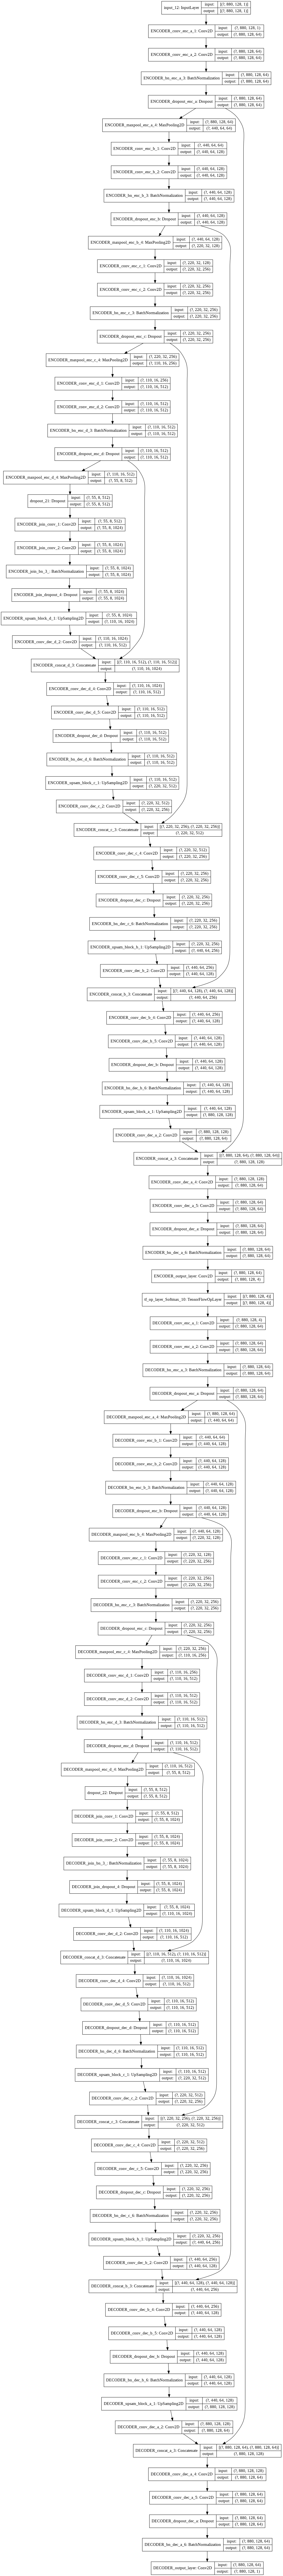

In [77]:
model = wnet(num_classes, size=[880, 128, 1])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 880, 128, 1) 0                                            
__________________________________________________________________________________________________
ENCODER_conv_enc_a_1 (Conv2D)   (None, 880, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
ENCODER_conv_enc_a_2 (Conv2D)   (None, 880, 128, 64) 36928       ENCODER_conv_enc_a_1[0][0]       
__________________________________________________________________________________________________
ENCODER_bn_enc_a_3 (BatchNormal (None, 880, 128, 64) 256         ENCODER_conv_enc_a_2[0][0]       
____________________________________________________________________________________________

## Seting up the model: learning rate, optimizer, loss function and trainable weights

In [0]:
#Instantiate learning rate
start_learning_rate = 1e-5 #0.00001
# lr = tf.train.exponential_decay(start_learning_rate, global_step_tensor, 5000, 0.999, staircase=True) #TF1
lr = tf.keras.optimizers.schedules.ExponentialDecay(start_learning_rate, decay_steps=5000, decay_rate=0.999, staircase=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Instantiate the loss functions.
def custom_loss(x, decode, output):
    soft_map = (x, output)
    loss = 0 #tf.map_fn(lambda x:soft_n_cut_loss(tf.reshape(tf.image.rgb_to_grayscale(x[0]), (img_rows*img_cols,)), tf.reshape(x[1], (img_rows, img_cols, num_classes)), num_classes, img_rows, img_cols), soft_map, dtype=x.dtype)
    loss = tf.reduce_mean(loss)/2
    recons_map = (x, decode)
    recons_loss = tf.map_fn(lambda x: tf.reduce_mean(tf.square(x[0] - x[1])), recons_map, dtype=x.dtype)
    recons_loss = tf.reduce_mean(recons_loss)
		#tf.summary.scalar('soft_n_cut_loss', loss)
		#tf.summary.scalar('reconstruction_loss', recons_loss)
    return loss, recons_loss


In [0]:
#Defining functions for visualizing

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

# **Training**

Start of epoch 0


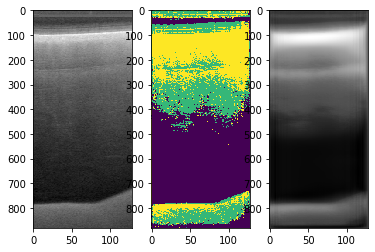

Training loss (for one batch) at step 0: loss: 0.0 recons_loss: 26.273700714111328
Seen so far: 4 samples


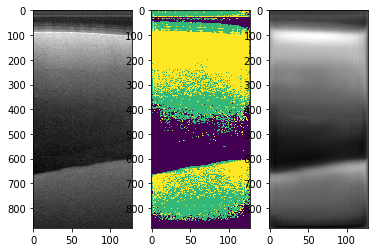

KeyboardInterrupt: ignored

In [36]:
#Define training loop

epochs = 3
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      output, decode = model(x_batch_train)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss, recons_loss = custom_loss(x_batch_train, decode, output)
      #print(loss)

    vars_encoder=[]
    # Obtain encoder variables
    for var in model.trainable_variables:
      if var.name.startswith("ENCODER"):
        vars_encoder.append(var)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    #enc_grads = tape.gradient(loss, vars_encoder)
    grads = tape.gradient(recons_loss, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    #optimizer.apply_gradients(zip(enc_grads, vars_encoder))
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    #Print result
    pred_mask = output[0]
    fig=plt.figure()

    fig.add_subplot(1,3,1)
    plt.imshow(np.squeeze(x_batch_train[0]), cmap='gray', aspect='auto')
    fig.add_subplot(1,3,2)
    plt.imshow(np.squeeze(create_mask(pred_mask)), aspect='auto')
    fig.add_subplot(1,3,3)
    plt.imshow(np.squeeze(decode[0]), cmap='gray', aspect='auto')
    plt.show()

    # Radargram reconstruction
    if step == 0:
      original = x_batch_train[0]
      original = tf.concat([original, x_batch_train[1], x_batch_train[2], x_batch_train[3]],1)
      imagen = create_mask(output[0])
      imagen = tf.concat([imagen, create_mask(output[1]), create_mask(output[2]), create_mask(output[3])],1)
    if step > 0 and step < 19:
      original = tf.concat([original, x_batch_train[0], x_batch_train[1], x_batch_train[2], x_batch_train[3]],1)
      imagen = tf.concat([imagen, create_mask(output[0]), create_mask(output[1]), create_mask(output[2]), create_mask(output[3])],1)

    # Log every 5 batches.
    if step % 5 == 0:
        print('Training loss (for one batch) at step %s: loss: %s recons_loss: %s' % (step, float(loss), float(recons_loss)))
        print('Seen so far: %s samples' % ((step + 1) * 4))

    if step == 19:
        print('Radargram recap')
        fig1=plt.figure()
        fig1.add_subplot(1,2,1)
        plt.imshow(np.squeeze(original), cmap='gray', aspect='auto')
        fig1.add_subplot(1,2,2)
        plt.imshow(np.squeeze(imagen), aspect='auto')
        plt.show()



# Final results
print('Final recap')
fig1=plt.figure()
fig1.add_subplot(1,2,1)
plt.imshow(np.squeeze(original), cmap='gray', aspect='auto')
fig1.add_subplot(1,2,2)
plt.imshow(np.squeeze(imagen), aspect='auto')
plt.show()


# **Validation**

(960, 6656)
tf.Tensor(
[[[-25.39476 ]
  [-24.474762]
  [-26.054749]
  ...
  [-25.28476 ]
  [-31.204758]
  [-28.964752]]

 [[-24.074753]
  [-24.614761]
  [-26.38475 ]
  ...
  [-29.864761]
  [-31.194763]
  [-28.694763]]

 [[-34.42476 ]
  [-30.28476 ]
  [-24.794754]
  ...
  [-28.484756]
  [-30.814758]
  [-28.63475 ]]

 ...

 [[-29.604752]
  [-28.994751]
  [-24.934753]
  ...
  [-23.554749]
  [-22.814758]
  [-21.734756]]

 [[-31.474762]
  [-27.924759]
  [-24.64476 ]
  ...
  [-22.374756]
  [-23.704758]
  [-24.114761]]

 [[-29.694763]
  [-26.214752]
  [-22.654755]
  ...
  [-20.954758]
  [-22.244751]
  [-23.574753]]], shape=(960, 128, 1), dtype=float32)


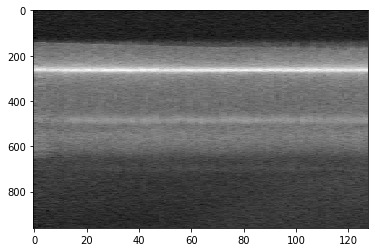

In [66]:
#Load dataset from a csv file
file = '/content/drive/My Drive/Per_Miguel/Dataset_ice_shelf/data_20181115_01/validation.csv'
df=pd.read_csv(file,header=None)
d=df.values
validation = np.float32(d)
validation=validation[:,0:6656] #78 patches
validation -= np.mean(validation) #mean substraction
print(validation.shape)

#Divide radargram into patches
validation=np.reshape(validation,(960,128,52), order = 'F')
validation = tf.transpose(validation, perm = [2, 0, 1])
validation = validation[..., tf.newaxis] #add 3rd dimension
a = validation[0,:,:,:] #checkpoint
plt.imshow(np.squeeze(a), cmap='gray', aspect='auto') 
print(validation[0,:,:,:])

validation = tf.data.Dataset.from_tensor_slices(validation)

#Set dataser propierties
#TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 100
STEPS_PER_EPOCH = 19

#Customize dataset
validation_dataset = validation.batch(BATCH_SIZE)

## Define model and load weights

In [79]:
model_1 = wnet(num_classes, size = [960, 128, 1])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1.load_weights(checkpoint_path)

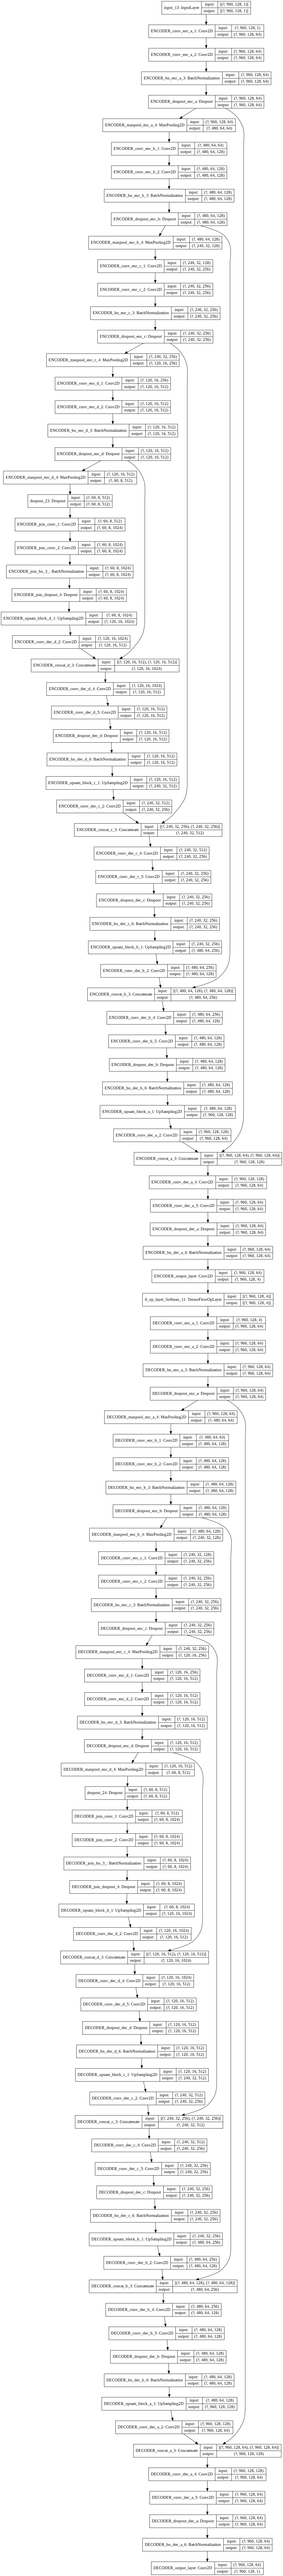

In [80]:
tf.keras.utils.plot_model(model_1, show_shapes=True)


## Validation dataset execution

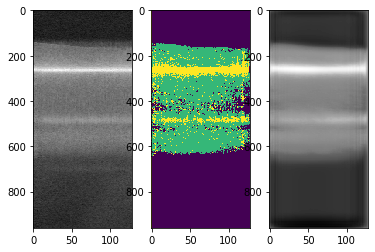

Training loss (for one batch) at step 0: loss: 0.0 recons_loss: 25.004756927490234
Seen so far: 4 samples


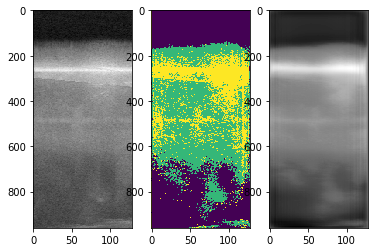

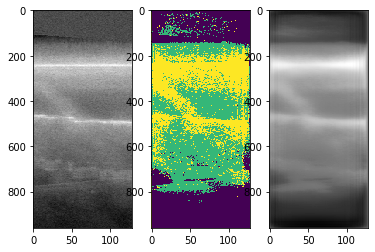

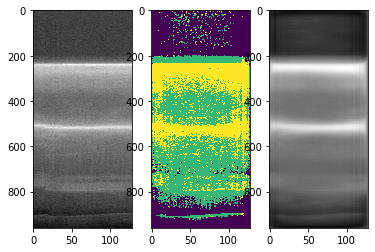

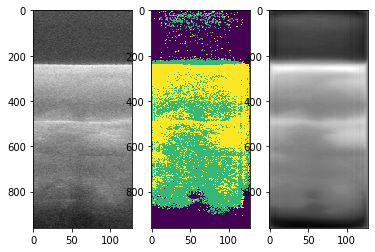

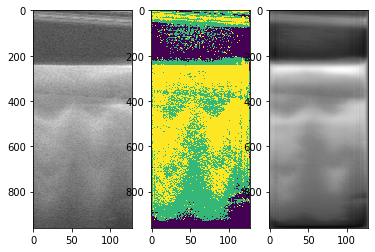

Training loss (for one batch) at step 5: loss: 0.0 recons_loss: 49.67311096191406
Seen so far: 24 samples


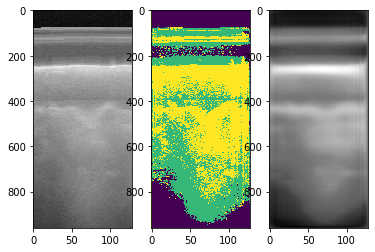

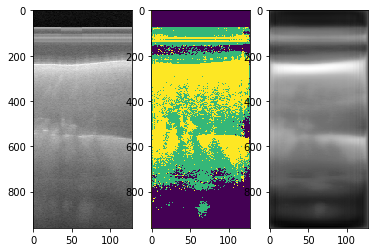

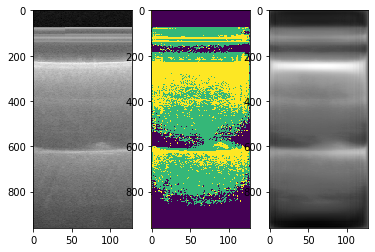

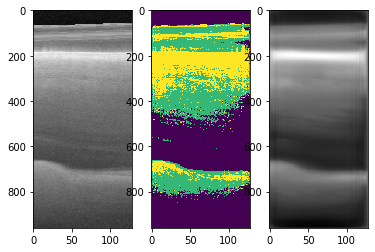

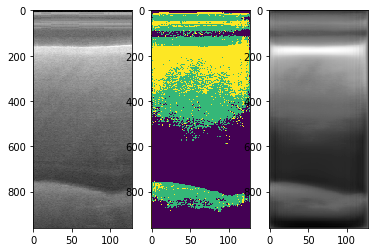

Training loss (for one batch) at step 10: loss: 0.0 recons_loss: 49.75830078125
Seen so far: 44 samples


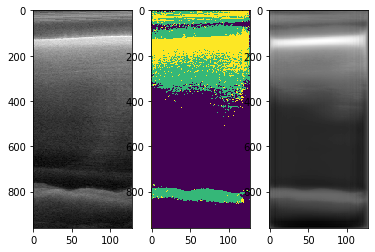

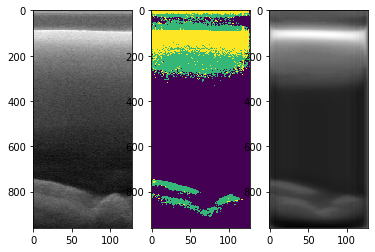

Final recap


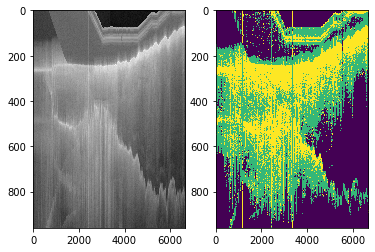

In [81]:
for step, (x_batch_validation) in enumerate(validation_dataset):

    output, decode = model_1(x_batch_validation)  # Logits for this minibatch

    # Compute the loss value for this minibatch.
    loss, recons_loss = custom_loss(x_batch_validation, decode, output)
    #print(loss)


    #Print result
    pred_mask = output[0]
    fig=plt.figure()

    fig.add_subplot(1,3,1)
    plt.imshow(np.squeeze(x_batch_validation[0]), cmap='gray', aspect='auto')
    fig.add_subplot(1,3,2)
    plt.imshow(np.squeeze(create_mask(pred_mask)), aspect='auto')
    fig.add_subplot(1,3,3)
    plt.imshow(np.squeeze(decode[0]), cmap='gray', aspect='auto')
    plt.show()

    # Radargram reconstruction
    if step == 0:
      original = x_batch_validation[0]
      original = tf.concat([original, x_batch_validation[1], x_batch_validation[2], x_batch_validation[3]],1)
      imagen = create_mask(output[0])
      imagen = tf.concat([imagen, create_mask(output[1]), create_mask(output[2]), create_mask(output[3])],1)
    if step > 0 and step < 19:
      original = tf.concat([original, x_batch_validation[0], x_batch_validation[1], x_batch_validation[2], x_batch_validation[3]],1)
      imagen = tf.concat([imagen, create_mask(output[0]), create_mask(output[1]), create_mask(output[2]), create_mask(output[3])],1)

    # Log every 5 batches.
    if step % 5 == 0:
        print('Training loss (for one batch) at step %s: loss: %s recons_loss: %s' % (step, float(loss), float(recons_loss)))
        print('Seen so far: %s samples' % ((step + 1) * 4))


# Final results
print('Final recap')
fig1=plt.figure()
fig1.add_subplot(1,2,1)
plt.imshow(np.squeeze(original), cmap='gray', aspect='auto')
fig1.add_subplot(1,2,2)
plt.imshow(np.squeeze(imagen), aspect='auto')
plt.show()

PRUEBAS

In [0]:
checkpoint_path = '/content/drive/My Drive/Per_Miguel/Dataset_ice_shelf/data_20181115_01/training_3/cp.ckpt'
model.save_weights(checkpoint_path)


In [33]:
recons_map = (x_batch_train, decode)
recons_loss = tf.map_fn(lambda x: tf.reduce_mean(tf.square(x[0] - x[1])), recons_map, dtype=x_batch_train.dtype)

reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(decode, x_batch_train)))
recons_loss = tf.reduce_mean(recons_loss)

mse = tf.keras.losses.MeanSquaredError()
loss = mse(x_batch_train, decode)

print(recons_loss)
print(reconstruction_error)
print(loss)

tf.Tensor(111.37625, shape=(), dtype=float32)
tf.Tensor(111.37626, shape=(), dtype=float32)
tf.Tensor(111.37626, shape=(), dtype=float32)


In [34]:
#a=create_mask(output[0])-create_mask(output[1])

#plt.imshow(np.squeeze(a), aspect='auto')
x_batch_train

<tf.Tensor: shape=(2, 880, 128, 1), dtype=float32, numpy=
array([[[[ -5.1199493],
         [ -4.359947 ],
         [ -3.47995  ],
         ...,
         [ -0.9299469],
         [ -2.2599487],
         [ -6.3799515]],

        [[ -3.4999466],
         [ -3.6699448],
         [ -1.0099487],
         ...,
         [ -0.9599457],
         [ -1.8599472],
         [ -3.5699463]],

        [[ -9.619949 ],
         [ -9.839951 ],
         [ -6.97995  ],
         ...,
         [ -1.2699509],
         [ -2.349945 ],
         [ -2.8099442]],

        ...,

        [[-20.189949 ],
         [-19.639946 ],
         [-17.39994  ],
         ...,
         [-21.779945 ],
         [-22.379951 ],
         [-24.439949 ]],

        [[-20.39994  ],
         [-19.509941 ],
         [-16.40995  ],
         ...,
         [-22.689949 ],
         [-24.529945 ],
         [-24.079948 ]],

        [[-20.479942 ],
         [-23.009941 ],
         [-20.179955 ],
         ...,
         [-21.349953 ],
         [-22.1199